## Install packages

In [1]:
%%capture
!python -m pip install --upgrade pip
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.databases #Package for database reading.
!pip install mne=="0.23" #The MNE Package is installed
FILEID = "1-bPsREsUCOiJHzIqi8DQrfSjTAf5VAW_"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MI_EEG_ClassMeth.zip && rm -rf /tmp/cookies.txt
!unzip MI_EEG_ClassMeth.zip #Package with useful functions for motor imagery classification based in EEG.

## Import

In [2]:
from typing import Dict

from gcpds.databases.BCI_Competition_IV import Dataset_2a
from google.colab.drive import mount
import numpy as np
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from MI_EEG_ClassMeth.FeatExtraction import Power_based_Connectivities
from mne import create_info
from mne.channels import make_standard_montage
from pickle import load as pload
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

## Utils

In [3]:
import numpy as np
from matplotlib import pyplot as plt


# ----------------------------------------------------------------------
def agco(method_1, method_2, ticks, labels, sort='method_1', reference_c='C1', gain_c='C0', loss_c='C3', barwidth=8, ylabel='Accuracy [%]', xlabel='Subjects', gain_labels=['gain', 'loss'], fig=None, ax=None, size=(15, 5), dpi=90, **kwargs):
    """"""
    if 'lose_c' in kwargs:
        loss_c = kwargs['lose_c']

    if fig is None:
        plt.figure(figsize=size, dpi=dpi)

    if ax is None:
        ax = plt.subplot(111)

    if sort is None:
        index = np.arange(len(method_2))
    elif sort == 'method_1':
        index = np.argsort(method_1)[::-1]
    elif sort == 'method_1r':
        index = np.argsort(method_1)
    elif sort == 'method_2':
        index = np.argsort(method_2)[::-1]
    elif sort == 'method_2r':
        index = np.argsort(method_2)

    colors = np.array(method_2[index]
                      - method_1[index] < 0, dtype=np.object_)

    if sort is None or sort.startswith('method_1'):
        p1, = plt.plot(method_1[index], color=reference_c, linestyle='--', linewidth=3)
        p2, = plt.plot(method_2[index], color=gain_c,
                       linestyle='--', linewidth=3, alpha=0.5)
        colors[colors == 0] = gain_c
        colors[colors == 1] = loss_c
    elif sort.startswith('method_2'):
        p1, = plt.plot(method_2[index], color=reference_c, linestyle='--',)
        p2, = plt.plot(method_1[index], color=gain_c,
                       linestyle='--', alpha=0.3)
        colors[colors == 0] = loss_c
        colors[colors == 1] = gain_c

    plots = [p1, p2]

    if np.array([colors == gain_c]).any():
        p3 = plt.vlines(np.array(sorted(index))[colors == gain_c], method_1[index][colors == gain_c],
                        method_2[index][colors == gain_c], color=colors[colors == gain_c], linewidth=barwidth)
        labels.append(gain_labels[0])
        plots.append(p3)

    if np.array([colors == loss_c]).any():
        p4 = plt.vlines(np.array(sorted(index))[colors == loss_c], method_1[index][colors == loss_c],
                        method_2[index][colors == loss_c], color=colors[colors == loss_c], linewidth=barwidth)
        labels.append(gain_labels[1])
        plots.append(p4)

    plt.ylabel(ylabel, fontsize=35)
    plt.xlabel(xlabel)
    plt.yticks(range(50, 101, 10), range(50, 101, 10), fontsize=25)
    plt.xticks(range(len(ticks)), ticks[index], rotation=90, fontsize=22)

    try:
        ax.spines.right.set_visible(False)
        ax.spines.top.set_visible(False)
    except:
        pass

    try:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    except:
        pass

    l1 = plt.legend(plots, labels, loc='upper center',
                    ncol=2, bbox_to_anchor=(0.5, 1), fontsize=25)
    plt.gca().add_artist(l1)

    return plt.gcf()

def plot_A(coord: np.ndarray, images: np.ndarray, zoom: float, cmap: str, ax):
  for i in range(coord.shape[0]):
      im = OffsetImage(squareform(images[i]), zoom = zoom, cmap = cmap)
      img = im.get_children()[0]
      img.set_clim(vmin=0, vmax=1)
      ab = AnnotationBbox(im, (coord[i,0], coord[i,1]), pad = 0.2)
      ax.add_artist(ab)
      ax.update_datalim([(coord[i,0], coord[i,1])])
      ax.autoscale()
      ax.text(coord[i,0], coord[i,1]+50, "S"+str(i+1), fontsize=18)
  return ax

## Variables definition

In [4]:
mount("/content/drive", force_remount=True)

parent_dir = '/content/drive/Shareddrives/GCPDS - Mateo/Mateo/MI_DL_models/BCICIV2a/'

db = Dataset_2a('/content/drive/Shareddrives/GCPDS-Databases/BCI_Competition_IV/dataset_2a')
fs = db.metadata['sampling_rate']
eeg_ch_names = db.metadata["channels"][:-3]
n_eeg_chs = len(eeg_ch_names)
montage = make_standard_montage(db.metadata['montage'])
info = create_info(eeg_ch_names, fs, len(eeg_ch_names)*['eeg'])
info.set_montage(montage)
subjects = np.arange(db.metadata['subjects']) + 1

seed = 23
pbc = Power_based_Connectivities()

raw_eegnet = np.load(parent_dir + 'EEGNet/raw_eegnet.npy')
reg_eegnet = np.load(parent_dir + 'RCKA_EEGNet/reg_eegnet.npy')
orig_raw_eegnet = raw_eegnet.copy()
orig_reg_eegnet = reg_eegnet.copy()
lambda_ = np.load(parent_dir + 'RCKA_EEGNet/lambda_.npy')
gammad = np.load(parent_dir + 'RCKA_EEGNet/gammad.npy')
H = np.load(parent_dir + 'RCKA_EEGNet/H.npy')
A_sbjs = np.load(parent_dir + 'RCKA_EEGNet/A_sbjs.npy')

Mounted at /content/drive


## Results

In [5]:
# Classification scores normalization
raw_eegnet[:, [1, 3, -1]] = 1 - raw_eegnet[:, [1, 3, -1]]
raw_eegnet[:, 2] = (raw_eegnet[:, 2] + 1)/2
reg_eegnet[:, [1, 3, -1]] = 1 - reg_eegnet[:, [1, 3, -1]]
reg_eegnet[:, 2] = (reg_eegnet[:, 2] + 1)/2

In [6]:
pca = PCA(n_components = 1, whiten = True).fit(raw_eegnet)
idx_ord_sbj = np.argsort(pca.transform(raw_eegnet)[:,0])

### Overall performance results

In [7]:
raw_eegnet_all_sbjs = np.concatenate([orig_raw_eegnet.mean(axis = 0, keepdims = True), orig_raw_eegnet.std(axis = 0, keepdims = True)], axis = 0)
reg_eegnet_all_sbjs = np.concatenate([orig_reg_eegnet.mean(axis = 0, keepdims = True), orig_reg_eegnet.std(axis = 0, keepdims = True)], axis = 0)

print('-----------------------------------------------------------------------------------')
print('Raw')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(raw_eegnet_all_sbjs[0, 0]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 0]*100, 1), ',mean_kappa = ', round(raw_eegnet_all_sbjs[0, 2]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 2]*100, 1), ',mean_auc', round(raw_eegnet_all_sbjs[0, 4]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------\n\n')

print('-----------------------------------------------------------------------------------')
print('Reg')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(reg_eegnet_all_sbjs[0, 0]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 0]*100, 1), ',mean_kappa = ', round(reg_eegnet_all_sbjs[0, 2]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 2]*100, 1), ',mean_auc', round(reg_eegnet_all_sbjs[0, 4]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 4]*100, 1))
print('-----------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------
Raw
-----------------------------------------------------------------------------------
mean_acc =  76.4 +/- 13.8 ,mean_kappa =  68.6 +/- 18.4 ,mean_auc 92.5 +/- 6.7
-----------------------------------------------------------------------------------


-----------------------------------------------------------------------------------
Reg
-----------------------------------------------------------------------------------
mean_acc =  78.0 +/- 13.3 ,mean_kappa =  70.7 +/- 17.8 ,mean_auc 92.6 +/- 6.6
-----------------------------------------------------------------------------------


In [8]:
ticks = ticks = np.asarray(['S' + str(sbj) for sbj in subjects[idx_ord_sbj]])

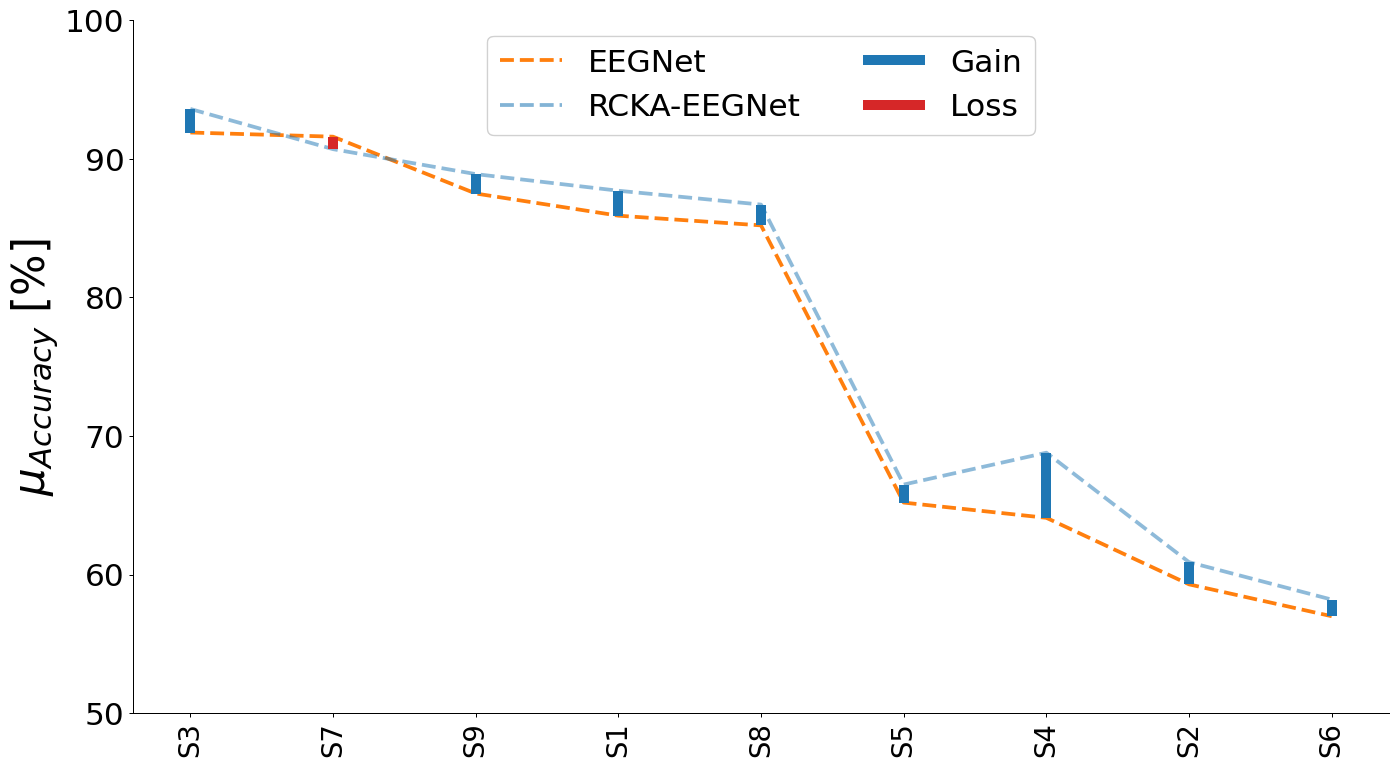

In [9]:
fig = agco( np.round(orig_raw_eegnet[idx_ord_sbj, 0]*100, 1),
     np.round(orig_reg_eegnet[idx_ord_sbj, 0]*100, 1),
     ticks,
     ['EEGNet', 'RCKA-EEGNet'],
     sort=None,
     gain_labels=['Gain', 'Loss'],
     gain_c='C0',
     loss_c='C3',
     ylabel = r'$\mu_{Accuracy}$ [%]',
     xlabel = '',
     size=(18, 10))

fig.savefig("sbjs_mean_acc.pdf")

In [10]:
print('-----------------------------------------------------------------------------------')
print('Raw')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(raw_eegnet_all_sbjs[0, 1]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 1]*100, 1), ',mean_kappa = ', round(raw_eegnet_all_sbjs[0, 3]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, 3]*100, 1), ',mean_auc', round(raw_eegnet_all_sbjs[0, -1]*100, 1), '+/-', round(raw_eegnet_all_sbjs[1, -1]*100, 1))
print('-----------------------------------------------------------------------------------\n\n')

print('-----------------------------------------------------------------------------------')
print('Reg')
print('-----------------------------------------------------------------------------------')
print('mean_acc = ', round(reg_eegnet_all_sbjs[0, 1]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 1]*100, 1), ',mean_kappa = ', round(reg_eegnet_all_sbjs[0, 3]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, 3]*100, 1), ',mean_auc', round(reg_eegnet_all_sbjs[0, -1]*100, 1), '+/-', round(reg_eegnet_all_sbjs[1, -1]*100, 1))
print('-----------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------
Raw
-----------------------------------------------------------------------------------
mean_acc =  3.6 +/- 1.9 ,mean_kappa =  4.8 +/- 2.5 ,mean_auc 1.5 +/- 1.2
-----------------------------------------------------------------------------------


-----------------------------------------------------------------------------------
Reg
-----------------------------------------------------------------------------------
mean_acc =  3.1 +/- 1.8 ,mean_kappa =  4.0 +/- 2.3 ,mean_auc 1.3 +/- 0.8
-----------------------------------------------------------------------------------


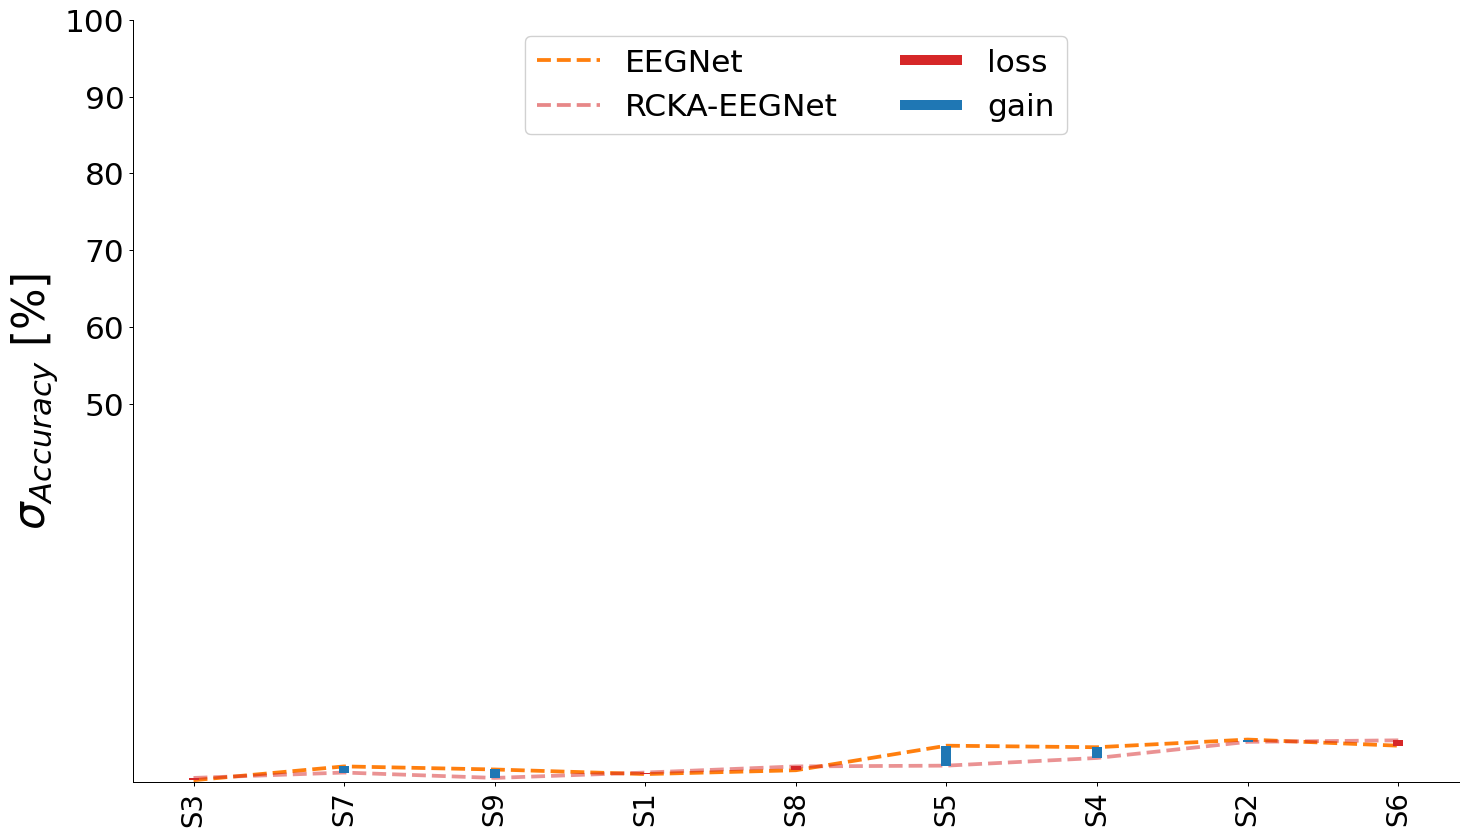

In [11]:
fig = agco( np.round(orig_raw_eegnet[idx_ord_sbj, 1]*100, 1),
     np.round(orig_reg_eegnet[idx_ord_sbj, 1]*100, 1),
     ticks,
     ['EEGNet', 'RCKA-EEGNet'],
     sort=None,
     gain_labels=['loss', 'gain'],
     gain_c='C3',
     loss_c='C0',
     ylabel = r'$\sigma_{Accuracy}$ [%]',
     xlabel = '',
     size=(19, 11))

fig.savefig("sbjs_std_acc.pdf")

In [12]:
(raw_eegnet[:,0] - reg_eegnet[:,0])*100

array([-1.8, -1.6, -1.7, -4.7, -1.3, -1.2,  0.9, -1.5, -1.4])

### Hyperparameters

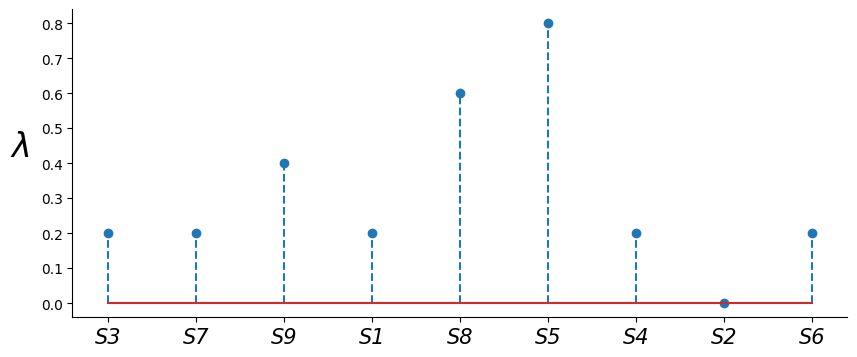

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

axs.stem(lambda_[idx_ord_sbj], linefmt="--", markerfmt="o")

axs.set_xticks(ticks=np.arange(subjects.shape[0]), labels=ticks, fontsize=15, style = 'italic')
axs.set_ylabel(r'$\lambda$', rotation = 0, fontsize = 24, labelpad = 15)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

fig.savefig("lambda.pdf")

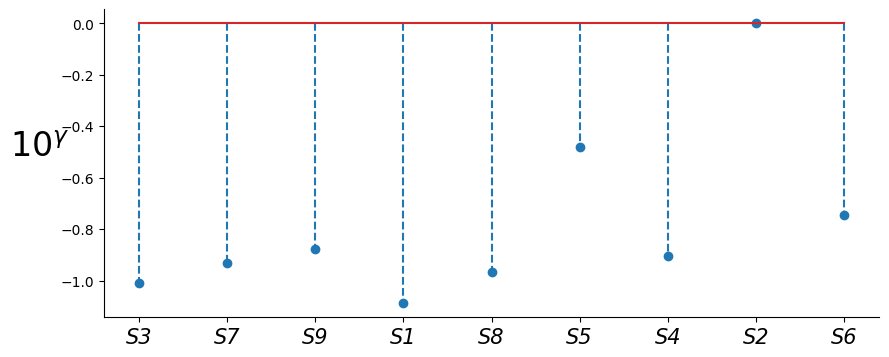

In [14]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

axs.stem(gammad[idx_ord_sbj], linefmt="--", markerfmt="o", bottom=-0)

axs.set_xticks(ticks=np.arange(subjects.shape[0]), labels=ticks, fontsize=15, style = 'italic')
axs.set_ylabel(r'$10^{\gamma}$', rotation = 0, fontsize = 24, labelpad = 15)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

fig.savefig("gammad.pdf")

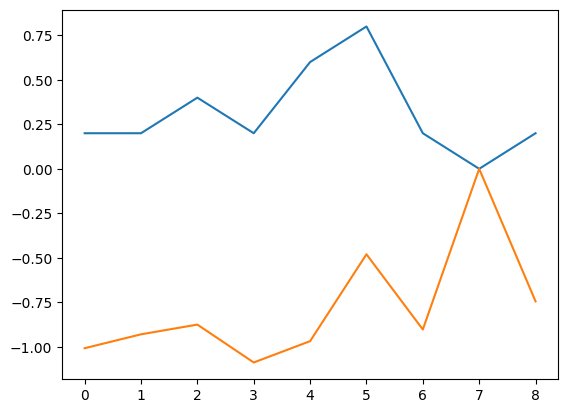

In [15]:
plt.plot(lambda_[idx_ord_sbj])
plt.plot(gammad[idx_ord_sbj])

### Intra subject variability

In [21]:
H[idx_ord_sbj]

array([1.63738564, 3.30016292, 1.8336576 , 1.92127641, 1.38128627,
       2.71252515, 2.69817548, 3.61004251, 3.05217126])

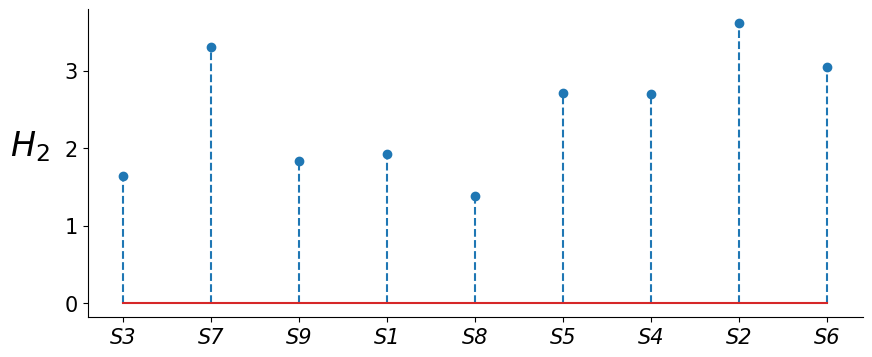

In [27]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

axs.stem(H[idx_ord_sbj], linefmt="--", markerfmt="o", bottom=0)

axs.set_xticks(ticks=np.arange(subjects.shape[0]), labels=ticks, fontsize=15, style = 'italic')
axs.set_yticks(ticks=np.arange(0, 4, 1), labels=np.round(np.arange(0, 4, 1), 1), fontsize=15)

axs.set_ylabel(r'$H_{2}$', rotation = 0, fontsize = 24, labelpad = 25)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

fig.savefig("renyis_entropy_2.pdf")

### Explanability

#### Performance vs FC pattern

In [17]:
dim_red = TSNE(n_components = 2, perplexity = 1, learning_rate = 'auto', init = 'pca', random_state = seed)
raw_eegnet_tsne = dim_red.fit_transform(raw_eegnet)
reg_eegnet_tsne = dim_red.fit_transform(reg_eegnet)

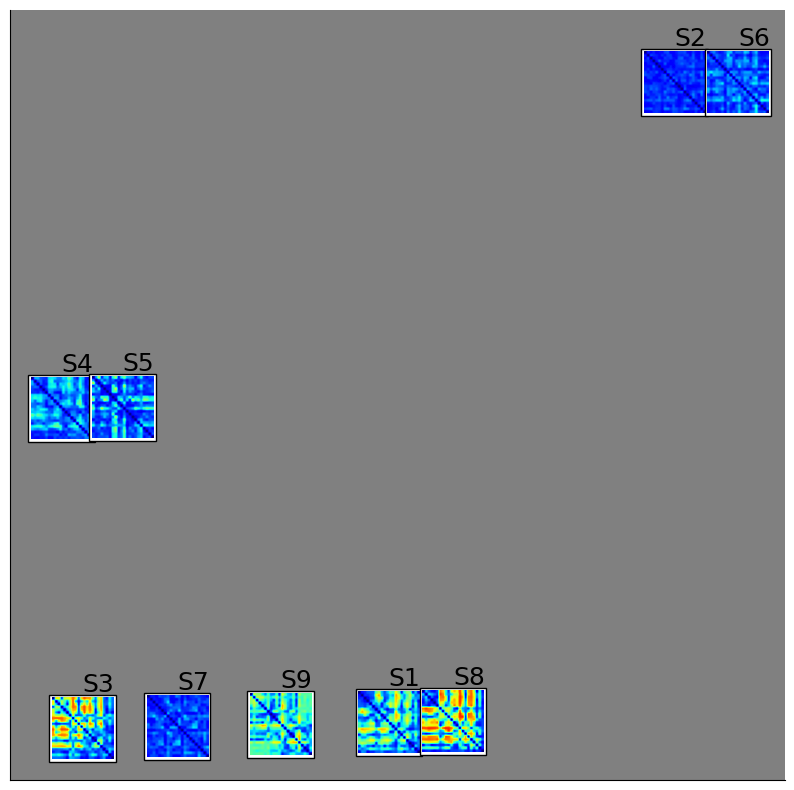

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

ax = plot_A(reg_eegnet_tsne, A_sbjs, 2, 'jet', ax)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-45, 45])
ax.set_ylim([-400, 650])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_facecolor('gray')
fig.savefig("kolmogorov_matrix.pdf")

#### Topoplots

In [19]:
coef = np.stack([A_sbjs[2], A_sbjs[3], A_sbjs[5]], axis=1)

/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay
/usr/local/lib/python3.10/dist-packages/mne/viz/topomap.py:469: DeprecationWarning: Please use `Delaunay` from the `scipy.spatial` namespace, the `scipy.spatial.qhull` namespace is deprecated.
  from scipy.spatial.qhull import Delaunay


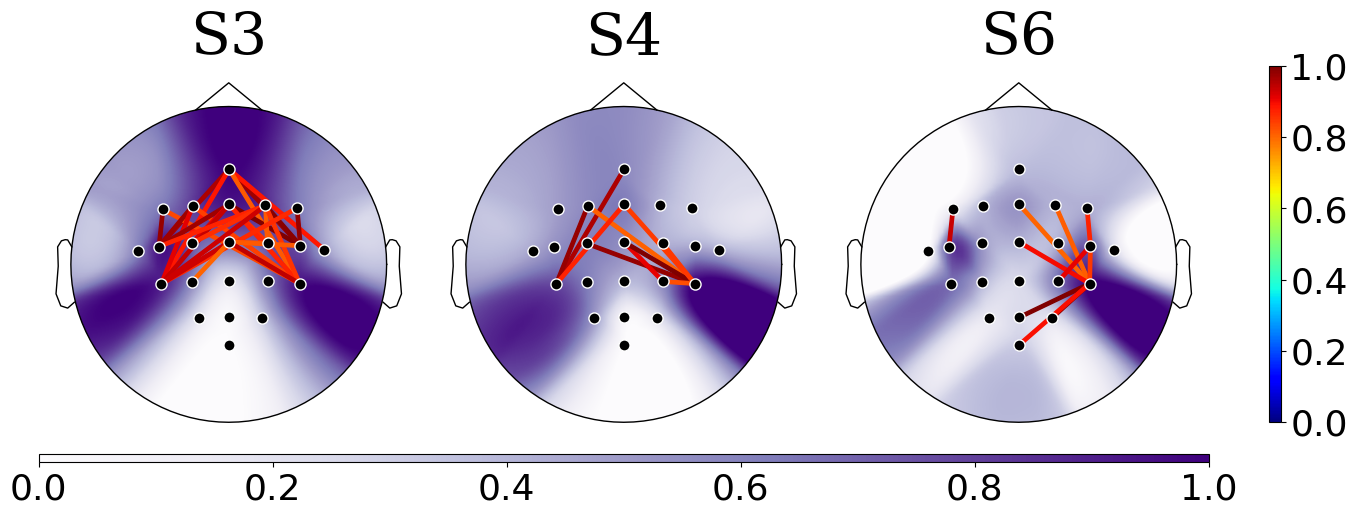

In [20]:
pbc.plot_connectivities(coef.reshape(-1).copy(), info, eeg_ch_names, n_vwt=1, n_f_bank=3, min_max_normalization_type="frequency", thr=0.8,
                        w_label=None, fb_label=['S3', 'S4', 'S6'], labels_params = {'ylabel_fonfamily':'serif', 'ylabel_fontsize':30, 'ylabel_weight':500, 'xlabel_fonfamily':'serif', 'xlabel_fontsize':42, 'xlabel_weight':500, 'rotation':0, 'cl_size':26},
                        relevant_channels=False, plot_channels_names=False, figsize=(12,8), cmap_connectivities='jet', cmap_tplt='Purples', save=True, path='group_topoplots', format='pdf')

- How to explain ?
- What are the main points to explain.